In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
#Reference

# https://www.kaggle.com/scr0ll0/august-2021-lgbm-xgb-catboost-optuna#3.-Optuna

# Import packages and dataset

In [2]:
import pandas as pd #dataframe manipulation
import numpy as np #linear algebra

#Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

np.random.seed(42)

In [3]:
# Display all results in a cell, not just the last line
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
from pandas_profiling import ProfileReport

In [5]:
train = pd.read_csv('customer_churn.csv')

# Exploratory Data Analysis

In [ ]:
profile = ProfileReport(train)
profile

profile.to_file('pandas_profiling_EDL.html')

In [ ]:
train.shape
train.info()
train.head()
train.describe()

In [ ]:
train.groupby('Churn')['customerID'].count()

Summary:

1. There are 7043 observations and 21 variables, including the target variable "Churn"
2. No missing value - great!
3. 21 variables: 17 categoricals, 1 unique identifier "customerID", 3 continuous variables
4. SeniorCitizen & MonthlyCharge, tenure & MonthlyCharges has positive correlation
5. There is an undersample of churned customer, represented by 'Yes' in the 'Churn' column. Not by much. Ratio is roughly 3:5. Need to investigate Recall & Precision to determine if problem.

Actionable:

1. One Hot Encoding categorical variables 
2. No rescaling needed
3. Need to change TotalCharges from object to float
4. Need to recalculate TotalCharges

# Data Preprocessing

In [6]:
#Convert TotalCharges to float instead of object
train['TotalCharges'] =pd.to_numeric(train['TotalCharges'], errors='coerce')

#Check for NaN value
train['TotalCharges'].isnull().sum()

#Drop NaN value
train.dropna(inplace=True)

11

In [7]:
#Convert target variable to binary, numeric variable
train['Churn'].replace(to_replace='Yes', value=1, inplace=True)
train['Churn'].replace(to_replace='No',  value=0, inplace=True)

In [8]:
#Remove customerID variable
train =train.drop(['customerID'], axis=1)

In [9]:
# One Hot Encoding categorical variable
df = pd.get_dummies(train)
df.head()
df.shape

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29.85,29.85,0,1,0,0,1,1,...,0,1,0,0,0,1,0,0,1,0
1,0,34,56.95,1889.50,0,0,1,1,0,1,...,0,0,1,0,1,0,0,0,0,1
2,0,2,53.85,108.15,1,0,1,1,0,1,...,0,1,0,0,0,1,0,0,0,1
3,0,45,42.30,1840.75,0,0,1,1,0,1,...,0,0,1,0,1,0,1,0,0,0
4,0,2,70.70,151.65,1,1,0,1,0,1,...,0,1,0,0,0,1,0,0,1,0


(7032, 46)

<Figure size 1080x576 with 0 Axes>

<AxesSubplot:>

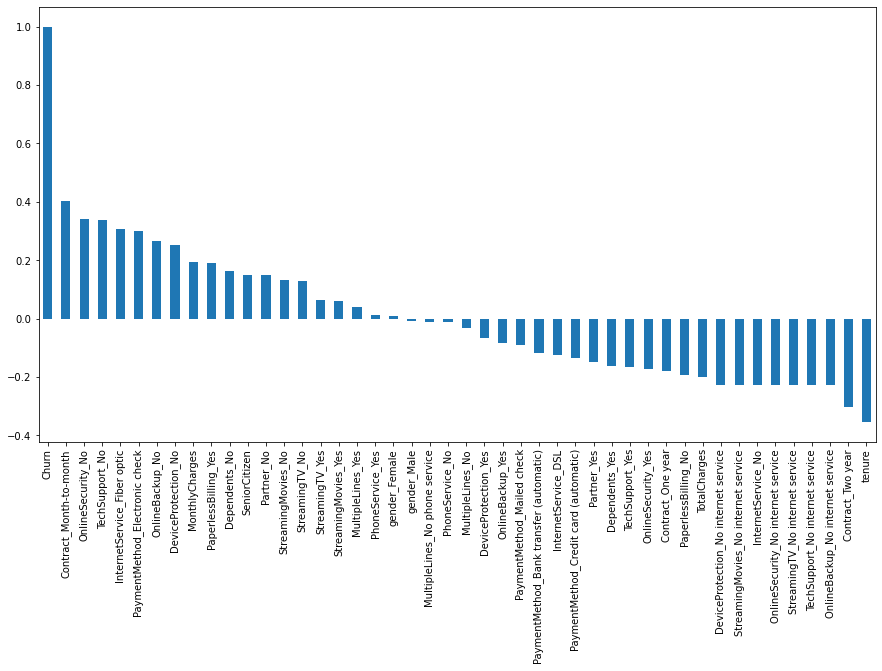

In [10]:
# Premilinary check for correlation with target variable aka feature importance
plt.figure(figsize=(15,8))
df.corr()['Churn'].sort_values(ascending =False).plot(kind='bar')

# Baseline Model with sk-learn

In [11]:
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, roc_auc_score

In [37]:
# Create X and y
y = df['Churn']
X = df.drop(['Churn'], axis=1)

In [13]:
# Scaling all variables to a range of 0 to 1 with MinMaxScaler

In [14]:
# Create train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [15]:
#Train a logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [16]:
# Score the trained model with test set
y_pred = model.predict(X_test)
print(roc_auc_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

0.7131511446059732
[[1381  168]
 [ 261  300]]


AxesSubplot(0.125,0.125;0.775x0.755)


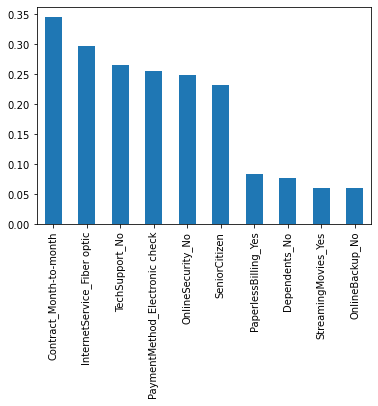

In [17]:
# Check feature importance
weights = pd.Series(model.coef_[0], index=X.columns.values)
print (weights.sort_values(ascending = False)[:10].plot(kind='bar'))

## Improve Baseline Model with RepeatedStratifiedKFold

In [30]:
#https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score

model = LogisticRegression()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=1)
print(np.mean(scores))

0.8438121273863255


# Advanced Algos to improve from Baseline

In [35]:
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score

from sklearn.metrics import confusion_matrix, roc_auc_score

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

In [45]:
rfc =RandomForestClassifier()
ada =AdaBoostClassifier()
xgbc =XGBClassifier(booster='gbtree', tree_method ='hist', verbosity=0, n_estimators=10000, learning_rate=0.05)
catbc =CatBoostClassifier()
lgbmc = LGBMClassifier(verbosity=0)

algos =[rfc,ada]
gradient=[xgbc,catbc,lgbmc]

In [32]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

for algo in algos:
    scores = cross_val_score(algo, X, y, scoring='roc_auc', cv=cv, verbose=0, n_jobs=1)
    print(str(algo))
    print(np.mean(scores))

RandomForestClassifier()
0.8187978148256244
AdaBoostClassifier()
0.8464419055982287


KeyboardInterrupt: 

In [46]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold = 0
scores = np.empty(5)
for train_idx, test_idx in cv.split(X, y):
    print(f"Started fold {fold}...")
    X_cv_train, y_cv_train = X.iloc[train_idx], y.iloc[train_idx]
    X_cv_test, y_cv_test = X.iloc[test_idx], y.iloc[test_idx]
    # Init/fit XGB
    model = xgbc
    model.fit(X_cv_train,y_cv_train,
              eval_set=[(X_cv_test, y_cv_test)],
              early_stopping_rounds=50,verbose=False)
    # Generate preds, evaluate
    preds = model.predict(X_cv_test)
    roc_auc = roc_auc_score(y_cv_test, preds)
    print("ROC_AUC of fold {}: {:.4f}\n".format(fold, roc_auc))
    scores[fold] = roc_auc
    fold += 1

print("Overall ROC_AUC: {:.4f}".format(np.mean(scores)))

Started fold 0...


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=10000, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='hist', validate_parameters=1, verbosity=0)

ROC_AUC of fold 0: 0.7179

Started fold 1...


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=10000, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='hist', validate_parameters=1, verbosity=0)

ROC_AUC of fold 1: 0.7173

Started fold 2...


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=10000, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='hist', validate_parameters=1, verbosity=0)

ROC_AUC of fold 2: 0.7044

Started fold 3...


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=10000, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='hist', validate_parameters=1, verbosity=0)

ROC_AUC of fold 3: 0.7097

Started fold 4...


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=10000, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='hist', validate_parameters=1, verbosity=0)

ROC_AUC of fold 4: 0.7272

Overall ROC_AUC: 0.7153


In [47]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold = 0
scores = np.empty(5)
for train_idx, test_idx in cv.split(X, y):
    print(f"Started fold {fold}...")
    X_cv_train, y_cv_train = X.iloc[train_idx], y.iloc[train_idx]
    X_cv_test, y_cv_test = X.iloc[test_idx], y.iloc[test_idx]
    # Init/fit XGB
    model = catbc
    model.fit(X_cv_train,y_cv_train,
              eval_set=[(X_cv_test, y_cv_test)],
              early_stopping_rounds=50,verbose=False)
    # Generate preds, evaluate
    preds = model.predict(X_cv_test)
    roc_auc = roc_auc_score(y_cv_test, preds)
    print("ROC_AUC of fold {}: {:.4f}\n".format(fold, roc_auc))
    scores[fold] = roc_auc
    fold += 1

print("Overall ROC_AUC: {:.4f}".format(np.mean(scores)))

Started fold 0...


ROC_AUC of fold 0: 0.7146

Started fold 1...


ROC_AUC of fold 1: 0.7175

Started fold 2...


ROC_AUC of fold 2: 0.7078

Started fold 3...


ROC_AUC of fold 3: 0.7115

Started fold 4...


ROC_AUC of fold 4: 0.7173

Overall ROC_AUC: 0.7137


In [48]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold = 0
scores = np.empty(5)
for train_idx, test_idx in cv.split(X, y):
    print(f"Started fold {fold}...")
    X_cv_train, y_cv_train = X.iloc[train_idx], y.iloc[train_idx]
    X_cv_test, y_cv_test = X.iloc[test_idx], y.iloc[test_idx]
    # Init/fit XGB
    model = lgbmc
    model.fit(X_cv_train,y_cv_train,
              eval_set=[(X_cv_test, y_cv_test)],
              early_stopping_rounds=50,verbose=False)
    # Generate preds, evaluate
    preds = model.predict(X_cv_test)
    roc_auc = roc_auc_score(y_cv_test, preds)
    print("ROC_AUC of fold {}: {:.4f}\n".format(fold, roc_auc))
    scores[fold] = roc_auc
    fold += 1

print("Overall ROC_AUC: {:.4f}".format(np.mean(scores)))

Started fold 0...
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000722 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines


LGBMClassifier(verbosity=0)

ROC_AUC of fold 0: 0.7075

Started fold 1...
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000943 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines


LGBMClassifier(verbosity=0)

ROC_AUC of fold 1: 0.7124

Started fold 2...
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002577 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines


LGBMClassifier(verbosity=0)

ROC_AUC of fold 2: 0.7027

Started fold 3...
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003460 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines


LGBMClassifier(verbosity=0)

ROC_AUC of fold 3: 0.7004

Started fold 4...
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000906 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines


LGBMClassifier(verbosity=0)

ROC_AUC of fold 4: 0.7239

Overall ROC_AUC: 0.7094


## Tune with optuna

In [ ]:
def objective(trial, data =X, target =y):
    
    param = {
            'n_estimators': trial.suggest_int('n_estimators', low =3000, high =12000, step =1000),    
            'max_depth': trial.suggest_int('max_depth', 8, 14),
            'learning_rate': trial.suggest_float('learning_rate ', low =0.002, high =0.02),
            'min_child_weight': trial.suggest_int('min_child_weight', 32, 512, step =32),
            'subsample': trial.suggest_discrete_uniform('subsample', 0.5, 0.9, 0.1),
            'colsample_bytree': trial.suggest_discrete_uniform('colsample_bytree', 0.5, 0.9, 0.1),
            'reg_alpha': trial.suggest_int('reg_alpha', 5, 60),
            'reg_lambda': trial.suggest_int('reg_lambda', 5, 60),
            'max_depth': trial.suggest_int('max_depth', 6, 20, 2),
            'n_jobs': 4,
#            'tree_method': 'gpu_hist', #only use with GPU
#            'predictor': 'gpu_predictor', #only use with GPU
            'tree_method': 'hist',
        }

    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.15,random_state=42)

    model = xgb.XGBRegressor(**param)   
    model.fit(train_x, train_y, eval_set=[(test_x, test_y)],
              early_stopping_rounds=100, verbose=False)
    
    preds = model.predict(test_x)
    rmse = mean_squared_error(test_y, preds,squared=False)
    return rmse

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
study.best_trial
study.best_trial.values
study.best_trial.params

In [ ]:
study.trials_dataframe()

In [ ]:
#plot_optimization_history: shows the scores from all trials as well as the best score so far at each point.
optuna.visualization.plot_optimization_history(study)

#plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
optuna.visualization.plot_parallel_coordinate(study)

#plot_slice: shows the evolution of the search. You can see where in the hyperparameter space your search
# went and which parts of the space were explored more
optuna.visualization.plot_slice(study)

#plot_contour: plots parameter interactions on an interactive chart. 
# You can choose which hyperparameters you would like to explore.
optuna.visualization.plot_contour(study, params=['alpha',
                            #'max_depth',
                            'lambda',
                            'subsample',
                            'learning_rate',
                            'subsample'])

#Visualize parameter importances.
optuna.visualization.plot_param_importances(study)

#Visualize empirical distribution function
optuna.visualization.plot_edf(study)

In [ ]:
Best_trial= study.best_trial.params


preds = np.zeros(test.shape[0])
kf = KFold(n_splits=5,random_state=48,shuffle=True)
rmse=[]  # list contains rmse for each fold
n=0

for trn_idx, test_idx in kf.split(train[columns],train['target']):
    X_tr,X_val=train[columns].iloc[trn_idx],train[columns].iloc[test_idx]
    y_tr,y_val=train['target'].iloc[trn_idx],train['target'].iloc[test_idx]
    
    model = xgb.XGBRegressor(**Best_trial)
    model.fit(X_tr,y_tr, 
              eval_set=[(X_val,y_val)], 
              early_stopping_rounds=100, 
              verbose=False)
    
    preds+=model.predict(test[columns])/kf.n_splits
    rmse.append(mean_squared_error(y_val, model.predict(X_val), squared=False))
    print(n+1,rmse[n])
    n+=1


np.mean(rmse)

In [ ]:
Best_trial= study.best_trial.params


splits = 12
stf = StratifiedKFold(n_splits=splits, shuffle=True)
oof= np.zeros((X.shape[0],))
prediction = 0
model_fi = 0
total_mean_rmse = 0

for num, (train_id, valid_id) in enumerate(stf.split(X, y)):
    X_train, X_valid = X.loc[train_id], X.loc[valid_id]
    y_train, y_valid = y.loc[train_id], y.loc[valid_id]
    
    model_xgb = XGBRegressor(**params)
    model_xgb.fit(X_train, y_train,
              eval_set=[(X_valid, y_valid)],
              early_stopping_rounds =200,
              eval_metric="rmse",
              verbose=False)
    
    prediction += model_xgb.predict(test) / splits
    oof[valid_id] = model_xgb.predict(X_valid)
    oof[oof < 0] = 0

    fold_rmse = np.sqrt(mean_squared_error(y_valid, oof[valid_id]))
    print(f"Fold {num} RMSE: {fold_rmse}")

In [ ]:
import joblib

# save the model to disk
filename = 'final_model_xgb.sav'
joblib.dump(model_xgb, filename)

# H2O AutoML

In [ ]:
#https://www.kaggle.com/keenborder/h20-automl-vs-boosting-models

In [49]:
import h2o
from h2o.automl import H2OAutoML

In [50]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; OpenJDK 64-Bit Server VM (build 11.0.6+8-b765.1, mixed mode)
  Starting server from C:\Users\Frank\anaconda3\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\Frank\AppData\Local\Temp\tmpir1yl1rh
  JVM stdout: C:\Users\Frank\AppData\Local\Temp\tmpir1yl1rh\h2o_Frank_started_from_python.out
  JVM stderr: C:\Users\Frank\AppData\Local\Temp\tmpir1yl1rh\h2o_Frank_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,America/Chicago
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.6
H2O_cluster_version_age:,24 days
H2O_cluster_name:,H2O_from_python_Frank_r8g138
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.967 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


In [51]:
train = h2o.import_file("customer_churn.csv")

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [53]:
x = train.columns
y = "Churn"
x.remove(y)
x.remove("customerID")

In [54]:
# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=20, seed=1,max_runtime_secs = 600)
aml.train(x=x, y=y, training_frame=train)

AutoML progress: |
19:21:39.817: AutoML: XGBoost is not available; skipping it.

████████████████████████████████████████████████████████| 100%


In [55]:
lb = aml.leaderboard
lb.head(rows=lb.nrows)

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_BestOfFamily_AutoML_20210912_192139,0.849937,0.410467,0.669833,0.233317,0.36487,0.13313
GBM_grid__1_AutoML_20210912_192139_model_1,0.849888,0.411075,0.668852,0.229478,0.364995,0.133221
StackedEnsemble_AllModels_AutoML_20210912_192139,0.849496,0.410619,0.670167,0.227974,0.365016,0.133237
GBM_grid__1_AutoML_20210912_192139_model_5,0.848468,0.412404,0.66646,0.228965,0.365799,0.133809
GBM_5_AutoML_20210912_192139,0.848376,0.412008,0.666555,0.229849,0.365693,0.133731
GBM_grid__1_AutoML_20210912_192139_model_3,0.847091,0.413564,0.664476,0.234499,0.366582,0.134382
GLM_1_AutoML_20210912_192139,0.845059,0.417473,0.651896,0.232852,0.3681,0.135498
GBM_1_AutoML_20210912_192139,0.84232,0.419352,0.658317,0.237548,0.369722,0.136694
GBM_2_AutoML_20210912_192139,0.839293,0.423633,0.650007,0.236353,0.371553,0.138052
GBM_grid__1_AutoML_20210912_192139_model_6,0.836674,0.427045,0.645654,0.240823,0.373467,0.139477


In [56]:
preds = aml.predict(test)

NameError: name 'test' is not defined

In [ ]:
# Convert submission to Dataframe, then to csv
submission=pd.DataFrame({
    "id": h2o.as_list(test["id"], use_pandas=True).values[:,0],
    "loss": h2o.as_list(preds, use_pandas=True).values[:,0]
    
})

submission.to_csv("submission.csv",index=False)